In [1]:
import numpy as np
import pandas as pd
import scipy.io
import warnings
from typing import Dict, Tuple, Any, Optional, List
import logging
from scipy import signal

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class IMUDataProcessor:
    """
    Handles processing of IMU data specific to right-arm worn sensors.
    """
    
    EXPECTED_SAMPLE_RATE = 50  # Hz
    
    @staticmethod
    def process_imu_data(data_struct: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Process IMU data from the structured array format.
        
        Args:
            data_struct: Structured array containing IMU data
            
        Returns:
            Dictionary containing processed sensor data
        """
        try:
            # Extract the IMU data fields
            data_fields = data_struct['data'][0][0][0]
            
            return {
                'accelerometer': data_fields['accelDataMatrix'][0],
                'gyroscope': data_fields['gyroDataMatrix'][0],
                'slave_accelerometer': data_fields['slaveAccelDataMatrix'][0],
                'slave_gyroscope': data_fields['slaveGyroDataMatrix'][0]
            }
        except Exception as e:
            logger.error(f"Error processing IMU data: {str(e)}")
            return None

class MatlabDataLoader:
    """
    A class to handle loading and processing the exercise data MATLAB file.
    """
    
    def __init__(self, file_path: str):
        """
        Initialize the loader with the path to the .mat file.
        
        Args:
            file_path (str): Path to the MATLAB file
        """
        self.file_path = file_path
        self.mat_contents = None
        self.imu_processor = IMUDataProcessor()
        self.activities = None
    
    def load_file(self) -> None:
        """
        Load the MATLAB file using scipy.io
        """
        try:
            self.mat_contents = scipy.io.loadmat(self.file_path)
            logger.info("File loaded successfully")
            
            # Load activities list immediately
            self.activities = [act[0] for act in self.mat_contents['exerciseConstants'][0,0]['activities'][0]]
            logger.info(f"Loaded {len(self.activities)} activities")
            
        except Exception as e:
            logger.error(f"Error loading file: {str(e)}")
            raise

    def process_exercise_instance(self, instance: np.ndarray) -> Optional[Dict[str, Any]]:
        """
        Process a single exercise instance from the subject_data array.
        
        Args:
            instance: Structured array containing exercise instance data
            
        Returns:
            Dictionary containing processed instance data or None if invalid
        """
        try:
            # Skip empty instances
            if instance.size == 0:
                return None
                
            # Basic instance information
            instance_data = {
                'masterFileToken': instance['masterFileToken'][0][0][0],
                'fileIndex': int(instance['fileIndex'][0,0].item()),
                'subjectIndex': int(instance['subjectIndex'][0,0].item()),
                'activityIndex': int(instance['activityIndex'][0,0].item()),
                'instanceIndex': int(instance['instanceIndex'][0,0].item()),
                'activityName': instance['activityName'][0,0].item(),
                'sampleRate': float(instance['sampleRate'][0,0].item())
            }
            
            # Optional fields that might be empty
            if instance['activityReps'][0,0].size > 0:
                instance_data['activityReps'] = int(instance['activityReps'][0,0].item())
            
            if instance['activityVideoStartTimeSeconds'][0,0].size > 0:
                instance_data['startTimeSeconds'] = float(instance['activityVideoStartTimeSeconds'][0,0].item())
            
            # Extract bounding window
            bounding = instance['boundingWindow'][0][0][0]
            instance_data.update({
                'startTime': float(bounding[0]),
                'endTime': float(bounding[1])
            })
            
            # Process IMU data if available
            imu_data = self.imu_processor.process_imu_data(instance)
            if imu_data:
                instance_data['imu_data'] = imu_data
            
            return instance_data
            
        except Exception as e:
            logger.debug(f"Error processing instance: {str(e)}")
            return None

    def process_all_data(self) -> List[Dict[str, Any]]:
        """
        Process all valid exercise instances in the subject_data array.
        
        Returns:
            List of dictionaries containing processed instance data
        """
        try:
            subject_data = self.mat_contents['subject_data']
            processed_instances = []
            
            # Track processing statistics
            total_instances = 0
            valid_instances = 0
            
            # Process each non-empty cell in the matrix
            for i in range(subject_data.shape[0]):
                for j in range(subject_data.shape[1]):
                    cell_data = subject_data[i, j]
                    total_instances += 1
                    
                    if cell_data.size > 0:
                        instance = self.process_exercise_instance(cell_data)
                        if instance:
                            valid_instances += 1
                            instance.update({
                                'matrix_row': i,
                                'matrix_col': j,
                                'activity_name': self.activities[j] if j < len(self.activities) else 'Unknown'
                            })
                            processed_instances.append(instance)
            
            logger.info(f"Processed {valid_instances} valid instances out of {total_instances} total cells")
            return processed_instances
            
        except Exception as e:
            logger.error(f"Error processing data: {str(e)}")
            raise

def load_and_process_matlab_data(file_path: str) -> Tuple[List[Dict[str, Any]], List[str]]:
    """
    Main function to load and process the MATLAB file.
    
    Args:
        file_path (str): Path to the MATLAB file
        
    Returns:
        Tuple containing:
        - processed_data: List of dictionaries containing processed exercise instances
        - activity_list: List of all possible activities
    """
    loader = MatlabDataLoader(file_path)
    
    try:
        # Load the file and activity list
        loader.load_file()
        
        # Process all exercise instances
        processed_data = loader.process_all_data()
        
        return processed_data, loader.activities
    
    except Exception as e:
        logger.error(f"Error in data loading and processing: {str(e)}")
        raise


def convert_to_timeseries_df(processed_data: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert processed MATLAB data into a time-series DataFrame.
    
    Args:
        processed_data: List of dictionaries containing processed exercise instances
        
    Returns:
        pandas DataFrame with columns [timestamp, acc_X, acc_Y, acc_Z, gyr_X, gyr_Y, gyr_Z, 
                                    activity_name, subject_id]
    """
    # List to store all data rows
    all_data = []
    
    for instance in processed_data:
        if 'imu_data' not in instance:
            continue
            
        # Get IMU data
        imu_data = instance['imu_data']
        accel_data = imu_data['accelerometer']
        gyro_data = imu_data['gyroscope']
        
        # Get metadata
        activity_name = instance['activityName']
        subject_id = instance['subjectIndex']
        start_time = instance['startTime']
        
        # Number of samples in this instance
        n_samples = accel_data.shape[0]
        
        # Create timestamps
        # First column of accel_data contains timestamps, but we'll also create relative timestamps
        timestamps = accel_data[:, 0]
        
        # Extract IMU data (assuming format is [timestamp, X, Y, Z])
        acc_x = accel_data[:, 1]
        acc_y = accel_data[:, 2]
        acc_z = accel_data[:, 3]
        
        gyr_x = gyro_data[:, 1]
        gyr_y = gyro_data[:, 2]
        gyr_z = gyro_data[:, 3]
        
        # Create data for this instance
        instance_data = {
            'timestamp': timestamps,
            'acc_X': acc_x,
            'acc_Y': acc_y,
            'acc_Z': acc_z,
            'gyr_X': gyr_x,
            'gyr_Y': gyr_y,
            'gyr_Z': gyr_z,
            'activity_name': [activity_name] * n_samples,
            'subject_id': [subject_id] * n_samples
        }
        
        # Convert to DataFrame
        df_instance = pd.DataFrame(instance_data)
        all_data.append(df_instance)
    
    # Concatenate all instances
    df_final = pd.concat(all_data, ignore_index=True)
    
    # Sort by timestamp
    df_final = df_final.sort_values('timestamp').reset_index(drop=True)
    
    return df_final

def filter_activities(df: pd.DataFrame, exclude_activities: List[str] = None) -> pd.DataFrame:
    """
    Filter out specified activities from the DataFrame.
    
    Args:
        df: Input DataFrame
        exclude_activities: List of activity names to exclude
        
    Returns:
        Filtered DataFrame
    """
    if exclude_activities is None:
        exclude_activities = [
            'Device on Table',
            # FIXME: Should we exclude 'Non-Exercise'?
            # 'Non-Exercise',
            'Tap Left Device',
            'Tap Right Device',
            'Arm Band Adjustment',
            'Initial Activity',
            'Invalid',
            'Note',
            'Unlisted Exercise'
        ]
    
    return df[~df['activity_name'].isin(exclude_activities)].reset_index(drop=True)


In [4]:
# Load your MATLAB file
file_path = "./exercise_data.50.0000_singleonly.mat"
processed_data, activity_list = load_and_process_matlab_data(file_path)

# Convert to DataFrame
df = convert_to_timeseries_df(processed_data)

# Filter out utility activities (optional)
df_filtered = filter_activities(df)

# Now df_filtered contains your data in the desired format:
df_filtered.head()

INFO:__main__:File loaded successfully
INFO:__main__:Loaded 75 activities
INFO:__main__:Processed 2056 valid instances out of 7050 total cells


,timestamp,acc_X,acc_Y,acc_Z,gyr_X,gyr_Y,gyr_Z,activity_name,subject_id
0,0.579996,-0.285950,-0.560462,0.657455,0.241546,4.569737,-2.864745,Non-Exercise,1
1,0.579998,-0.888628,-0.393786,0.014697,-27.270552,-22.655940,-4.860355,Non-Exercise,1
2,0.599996,-0.294014,-0.581006,0.674322,0.460580,4.604697,-1.598031,Non-Exercise,1
3,0.599998,-0.874913,-0.408958,0.030406,-24.414439,-21.656710,-5.411536,Non-Exercise,1
4,0.619996,-0.301693,-0.604563,0.692915,1.009780,2.715506,-0.693959,Non-Exercise,1


In [6]:
df_filtered['activity_name'].unique()

array(['Non-Exercise',
       'Two-arm Dumbbell Curl (both arms, not alternating)',
       'Pushup (knee or foot variation)', 'Shoulder Press (dumbbell)',
       'Jumping Jacks', 'Tap IMU Device', 'Kettlebell Swing',
       'Rowing machine', 'Repetitive Stretching', 'Arm straight up',
       'Triceps extension (lying down)', 'Dip',
       'Squat (arms in front of body, parallel to ground)',
       'Seated Back Fly', 'Jump Rope', 'Plank', 'V-up', 'Russian Twist',
       'Static Stretch (at your own pace)',
       'Triceps extension (lying down) (right arm)', 'Biceps Curl (band)',
       'Overhead Triceps Extension', 'Squat Jump', 'Butterfly Sit-up',
       'Elliptical machine', 'Dumbbell Row (knee on bench) (left arm)',
       'Triceps extension (lying down) (left arm)',
       'Dumbbell Row (knee on bench) (right arm)',
       'Dumbbell Row (knee on bench) (label spans both arms)',
       'Lunge (alternating both legs, weight optional)', 'Wall Squat',
       'Sit-ups', 'Sit-up (hands p

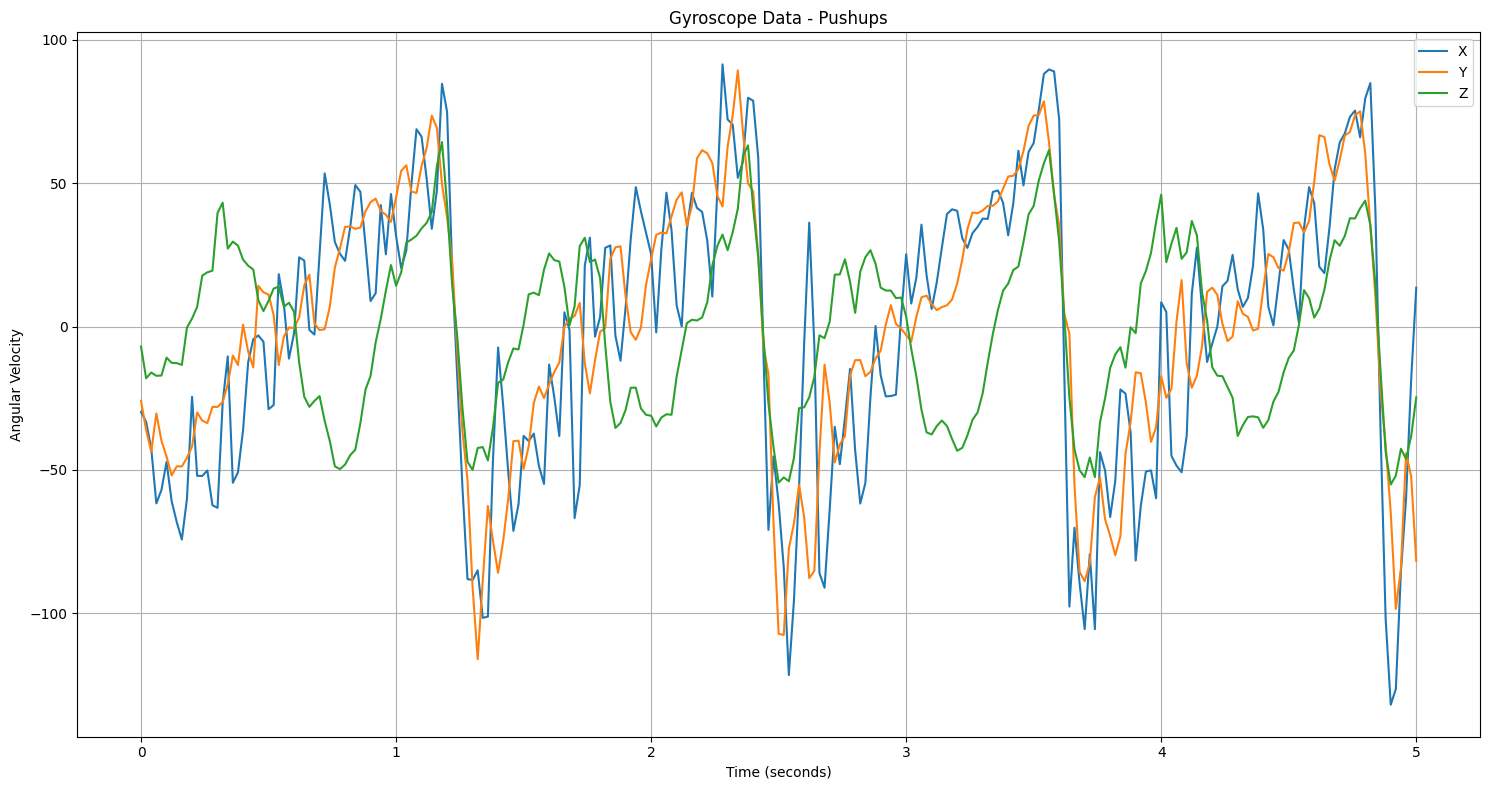

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Union, List

def plot_imu_data(df: pd.DataFrame,
                 activity: str,
                 sensor_type: str = 'both',
                 time_window: Optional[float] = None,
                 instance_index: int = 0,
                 figsize: tuple = (15, 8)) -> None:
    """
    Plot IMU data for a specific activity.
    
    Args:
        df: DataFrame containing IMU data
        activity: Name of the activity to plot
        sensor_type: 'acc' for accelerometer, 'gyr' for gyroscope, or 'both' for both
        time_window: Number of seconds to plot (None for entire activity)
        instance_index: Which instance of the activity to plot (if multiple exist)
        figsize: Figure size for the plot
    """
    # Filter data for the specified activity
    activity_data = df[df['activity_name'] == activity].copy()
    
    if activity_data.empty:
        print(f"No data found for activity: {activity}")
        return
    
    # Get unique instances based on continuous timestamps
    activity_data['time_diff'] = activity_data['timestamp'].diff()
    instance_breaks = activity_data[activity_data['time_diff'] > 1].index
    instance_indices = np.split(activity_data.index, instance_breaks)
    
    if instance_index >= len(instance_indices):
        print(f"Instance index {instance_index} is out of range. Maximum available: {len(instance_indices)-1}")
        return
    
    # Get data for the specified instance
    instance_data = activity_data.loc[instance_indices[instance_index]]
    
    # Adjust timestamps to start from 0
    instance_data['relative_time'] = instance_data['timestamp'] - instance_data['timestamp'].iloc[0]
    
    # Apply time window if specified
    if time_window is not None:
        instance_data = instance_data[instance_data['relative_time'] <= time_window]
    
    # Create the plot
    if sensor_type == 'both':
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plot accelerometer data
    if sensor_type in ['acc', 'both']:
        ax1.plot(instance_data['relative_time'], instance_data['acc_X'], label='X', color='#1f77b4')
        ax1.plot(instance_data['relative_time'], instance_data['acc_Y'], label='Y', color='#ff7f0e')
        ax1.plot(instance_data['relative_time'], instance_data['acc_Z'], label='Z', color='#2ca02c')
        ax1.set_title(f'Accelerometer Data - {activity}')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Acceleration')
        ax1.grid(True)
        ax1.legend()
    
    # Plot gyroscope data
    if sensor_type in ['gyr', 'both']:
        ax = ax2 if sensor_type == 'both' else ax1
        ax.plot(instance_data['relative_time'], instance_data['gyr_X'], label='X', color='#1f77b4')
        ax.plot(instance_data['relative_time'], instance_data['gyr_Y'], label='Y', color='#ff7f0e')
        ax.plot(instance_data['relative_time'], instance_data['gyr_Z'], label='Z', color='#2ca02c')
        ax.set_title(f'Gyroscope Data - {activity}')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Angular Velocity')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def get_activity_instances(df: pd.DataFrame, activity: str) -> int:
    """
    Get the number of instances available for a specific activity.
    
    Args:
        df: DataFrame containing IMU data
        activity: Name of the activity
    
    Returns:
        Number of instances found
    """
    activity_data = df[df['activity_name'] == activity].copy()
    
    if activity_data.empty:
        return 0
    
    activity_data['time_diff'] = activity_data['timestamp'].diff()
    instance_breaks = activity_data[activity_data['time_diff'] > 1].index
    return len(np.split(activity_data.index, instance_breaks))

def list_available_activities(df: pd.DataFrame) -> pd.Series:
    """
    List all available activities and their instance counts.
    
    Args:
        df: DataFrame containing IMU data
    
    Returns:
        Series containing activity counts
    """
    return df['activity_name'].value_counts()

# Example usage:
"""

# Plot both accelerometer and gyroscope data for a complete squat
plot_imu_data(df, activity='Squat', sensor_type='both')

# Check how many instances of an activity exist
n_instances = get_activity_instances(df, 'Bicep Curl')
print(f"Number of Bicep Curl instances: {n_instances}")

# List all available activities
activities = list_available_activities(df)
print("\nAvailable activities:")
print(activities)
"""

# Plot accelerometer data for a bicep curl over 5 seconds
plot_imu_data(df, activity='Pushups', sensor_type='gyr', time_window=5)
